In [1]:
%pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
%pip install fedml
%pip install scikit-learn pandas
%pip install imbalanced-learn
%pip install matplotlib seaborn
%pip install tqdm

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
%pip install opencv-python

     ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
      --------------------------------------- 0.6/39.5 MB 20.5 MB/s eta 0:00:02
     - -------------------------------------- 1.5/39.5 MB 19.3 MB/s eta 0:00:02
     -- ------------------------------------- 2.2/39.5 MB 15.2 MB/s eta 0:00:03
     -- ------------------------------------- 2.8/39.5 MB 16.1 MB/s eta 0:00:03
     --- ------------------------------------ 3.4/39.5 MB 16.8 MB/s eta 0:00:03
     ---- ----------------------------------- 4.1/39.5 MB 16.4 MB/s eta 0:00:03
     ---- ----------------------------------- 4.8/39.5 MB 17.1 MB/s eta 0:00:03
     ----- ---------------------------------- 5.5/39.5 MB 16.7 MB/s eta 0:00:03
     ------ --------------------------------- 6.2/39.5 MB 16.5 MB/s eta 0:00:03
     ------- -------------------------------- 7.0/39.5 MB 17.2 MB/s eta 0:00:02
     ------- -------------------------------- 7.7/39.5 MB 17.0 MB/s eta 0:00:02
     -------- ------------------------------- 8.


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install opacus==1.3.0


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
#  Differential Privacy with Opacus
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
#  Federated Learning (FedML)
from fedml import FedMLRunner  
#  Data Handling and ML Evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
#  Imbalanced Data Handling
from imblearn.over_sampling import SMOTE, ADASYN
#  Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#  Progress Bar
from tqdm import tqdm
#  System & Debugging
import os
import random
import warnings
warnings.filterwarnings("ignore")
#  Check GPU device
print(" Torch version:", torch.__version__)
print(" CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(" GPU device:", torch.cuda.get_device_name(0))


 Torch version: 2.0.1+cu118
 CUDA available: True
 GPU device: NVIDIA T1000 8GB


Define Global Configurations



In [ ]:
import torch
import random
import numpy as np
class Args:
    # Data and model config
    image_size = 224
    num_classes = 3  # 0: COVID, 1: Pneumonia, 2: Normal
    batch_size = 32
    lr = 0.01
    epochs = 7

    # Differential privacy config 
    noise_multiplier = 1.0
    max_grad_norm = 1.0
    delta = 1e-5  # For epsilon calculation

    # Federated Learning config
    round_count = 10              
    client_sizes = [3, 7, 10, 13]  
    initial_clients = 6           
    drop_rate = 0.2                

    # Hardware config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Seed for reproducibility
    seed = 42

args = Args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

print("Configuration loaded. Using device:", args.device)


Configuration loaded. Using device: cuda


Load and Clean dataset


In [30]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import os
import random

img_transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def collect_image_paths(folder_path, label):
    dataset = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder_path, fname)
            dataset.append((img_path, label))
    return dataset

covid_path = "COVID-19_Radiography_Dataset"
covid_images = collect_image_paths(os.path.join(covid_path, "COVID/images"), label=0)
viral_images = collect_image_paths(os.path.join(covid_path, "Viral_Pneumonia/images"), label=1)
lung_opacity_images = collect_image_paths(os.path.join(covid_path, "Lung_Opacity/images"), label=1)
normal_images_covid = collect_image_paths(os.path.join(covid_path, "Normal/images"), label=2)

pneu_path = "chest_xray"
normal_images_pneu = collect_image_paths(os.path.join(pneu_path, "train/NORMAL"), label=2)
pneumonia_images = collect_image_paths(os.path.join(pneu_path, "train/PNEUMONIA"), label=1)

all_image_paths = (
    covid_images +
    viral_images +
    lung_opacity_images +
    normal_images_covid +
    normal_images_pneu +
    pneumonia_images
)

print(f" Total image paths collected: {len(all_image_paths)}")

def split_train_test(data, test_size=0.2, random_state=42):
 
    paths = [item[0] for item in data]
    labels = [item[1] for item in data]
    
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=labels
    )

    train_data = list(zip(train_paths, train_labels))
    test_data = list(zip(test_paths, test_labels))
    
    return train_data, test_data


train_image_paths, test_image_paths = split_train_test(all_image_paths, test_size=0.2, random_state=42)

print(f" Train set size: {len(train_image_paths)} samples")
print(f" Test set size: {len(test_image_paths)} samples")

def print_class_distribution(data, dataset_name):
    class_counts = {}
    for _, label in data:
        class_counts[label] = class_counts.get(label, 0) + 1
    
    print(f"\n {dataset_name} class distribution:")
    class_names = {0: "COVID", 1: "Pneumonia", 2: "Normal"}
    for label, count in class_counts.items():
        print(f"   {class_names[label]} (Label {label}): {count} samples")

print_class_distribution(train_image_paths, "Training")
print_class_distribution(test_image_paths, "Testing")
class XrayLazyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path_or_img, label = self.data[idx]
        try:
            if isinstance(path_or_img, str):
                img = Image.open(path_or_img).convert("RGB")
            else:
                img = path_or_img

            if self.transform:
                img = self.transform(img)
            return img, label

        except Exception as e:
            print(f" Skipping {path_or_img} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self.data)) 

train_dataset = XrayLazyDataset(train_image_paths, transform=img_transform)
test_dataset = XrayLazyDataset(test_image_paths, transform=img_transform)

print(f" Training dataset ready with {len(train_dataset)} samples.")
print(f" Testing dataset ready with {len(test_dataset)} samples.")

def create_client_datasets(train_data, test_data, num_clients):
    random.shuffle(train_data)
    random.shuffle(test_data)
    
    # Calculate samples per client
    train_samples_per_client = len(train_data) // num_clients
    test_samples_per_client = len(test_data) // num_clients
    
    client_datasets = {}
    
    for client_id in range(num_clients):
        train_start = client_id * train_samples_per_client
        train_end = (client_id + 1) * train_samples_per_client if client_id < num_clients - 1 else len(train_data)
        
        test_start = client_id * test_samples_per_client
        test_end = (client_id + 1) * test_samples_per_client if client_id < num_clients - 1 else len(test_data)
        
        # Create client-specific data
        client_train_data = train_data[train_start:train_end]
        client_test_data = test_data[test_start:test_end]
        
        # Create datasets for this client
        client_train_dataset = XrayLazyDataset(client_train_data, transform=img_transform)
        client_test_dataset = XrayLazyDataset(client_test_data, transform=img_transform)
        
        client_datasets[f'client_{client_id}'] = {
            'train': client_train_dataset,
            'test': client_test_dataset
        }
        
        print(f" Client {client_id}: Train={len(client_train_dataset)}, Test={len(client_test_dataset)}")
    
    return client_datasets

 Total image paths collected: 26381
 Train set size: 21104 samples
 Test set size: 5277 samples

 Training class distribution:
   Pneumonia (Label 1): 8985 samples
   Normal (Label 2): 9226 samples
   COVID (Label 0): 2893 samples

 Testing class distribution:
   COVID (Label 0): 723 samples
   Pneumonia (Label 1): 2247 samples
   Normal (Label 2): 2307 samples
 Training dataset ready with 21104 samples.
 Testing dataset ready with 5277 samples.


Plot the distribution


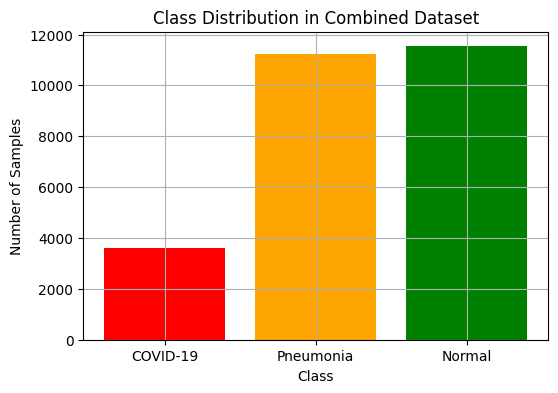

 Label counts: Counter({'Normal': 11533, 'Pneumonia': 11232, 'COVID-19': 3616})


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Use the already collected image paths and labels
all_labels = [label for _, label in all_image_paths]

# Label mapping for display
label_map = {0: "COVID-19", 1: "Pneumonia", 2: "Normal"}
label_names = [label_map[l] for l in all_labels]

counter = Counter(label_names)

plt.figure(figsize=(6, 4))
plt.bar(counter.keys(), counter.values(), color=["red", "orange", "green"])
plt.title("Class Distribution in Combined Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

print(" Label counts:", counter)


Data Agumentation

In [ ]:

from torchvision import transforms

base_transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Augmented transform: for training or oversampled data (COVID)
augmented_transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print(" Augmentation transforms defined")


 Augmentation transforms defined


Split the data among the clients and smote the minority class

In [ ]:
import random
from collections import defaultdict, Counter
from PIL import Image
from torchvision import transforms

covid_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])


label_map = {0: "COVID", 1: "Pneumonia", 2: "Normal"}
class_data = defaultdict(list)

for path, label in all_image_paths:
    class_data[label].append((path, label))

print("Original class counts:")
for lbl, items in class_data.items():
    print(f" - {label_map[lbl]}: {len(items)}")

target_class_size = max(len(v) for v in class_data.values())
augmented_covid_data = class_data[0].copy()

while len(augmented_covid_data) < target_class_size:
    img_path, label = random.choice(class_data[0])
    try:
        img = Image.open(img_path).convert("RGB")
        aug_img = covid_augment(img)
        augmented_covid_data.append((aug_img, label))  
    except Exception as e:
        print(f" Augmentation failed on {img_path}: {e}")

combined_dataset = (
    augmented_covid_data +
    class_data[1] +  # Pneumonia
    class_data[2]    # Normal
)

random.shuffle(combined_dataset)
print(f" Combined + balanced dataset size: {len(combined_dataset)}")

def split_among_clients(dataset, num_clients, train_ratio=0.8):
    random.shuffle(dataset)
    total = len(dataset)
    split_size = total // num_clients
    clients = {}

    for i in range(num_clients):
        start = i * split_size
        end = (i + 1) * split_size if i != num_clients - 1 else total
        client_data = dataset[start:end]

        # Train-test split
        split_idx = int(train_ratio * len(client_data))
        train_data = client_data[:split_idx]
        test_data = client_data[split_idx:]

        clients[i] = {
            'train': train_data,
            'test': test_data
        }

        print(f"Client {i}: {len(train_data)} train, {len(test_data)} test samples")

    return clients

client_datasets = split_among_clients(combined_dataset, args.initial_clients)

print(f" Created {args.initial_clients} federated clients with train-test splits.")


Original class counts:
 - COVID: 3616
 - Pneumonia: 11232
 - Normal: 11533
 Combined + balanced dataset size: 34298
Client 0: 4572 train, 1144 test samples
Client 1: 4572 train, 1144 test samples
Client 2: 4572 train, 1144 test samples
Client 3: 4572 train, 1144 test samples
Client 4: 4572 train, 1144 test samples
Client 5: 4574 train, 1144 test samples
 Created 6 federated clients with train-test splits.


Load and Customize DenseNet121

In [12]:

from torchvision.models import densenet121

model = densenet121(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  

num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, args.num_classes)
model = model.to(args.device)


Local Training with Opacus

In [14]:
from opacus import PrivacyEngine
from torch.utils.data import DataLoader
import copy
import torch
import torch.nn as nn

def train_local_model(client_id, model, train_data, test_data, args):
    # Deep copy the global model
    model = copy.deepcopy(model).to(args.device)
    model.train()

    # Dataloaders
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

    # Optimizer and loss
    # optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Attach Privacy Engine
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=args.noise_multiplier,
        max_grad_norm=args.max_grad_norm,
    )

    # Training loop
    for epoch in range(args.epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(args.device), labels.to(args.device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[Client {client_id}] Epoch {epoch+1}/{args.epochs}, Loss: {running_loss:.4f}")

    # Evaluation on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(args.device), labels.to(args.device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"[Client {client_id}] Test Accuracy: {acc:.2f}%")

    # Privacy accounting
    epsilon = privacy_engine.get_epsilon(delta=args.delta)
    print(f"[Client {client_id}] Training done. ε = {epsilon:.2f}")

    return model.state_dict(), epsilon


FedAvg


In [ ]:
import copy
def fed_avg(client_weights):
    avg_weights = copy.deepcopy(client_weights[0])

    # Sum all the client weights
    for key in avg_weights.keys():
        for i in range(1, len(client_weights)):
            avg_weights[key] += client_weights[i][key]
        avg_weights[key] = avg_weights[key] / len(client_weights)

    return avg_weights


Inttermittent Client Updates

In [ ]:
def select_clients(client_datasets, round_idx, drop_rate=0.2, seed=None):
    total_clients = len(client_datasets)
    available_clients = list(client_datasets.keys())
    if seed is not None:
        random.seed(seed + round_idx)  # Different pattern each round, but reproducible
    elif hasattr(args, "seed"):
        random.seed(args.seed + round_idx)
    num_drop = int(total_clients * drop_rate)
    random.shuffle(available_clients)
    selected_clients = available_clients[num_drop:]

    print(f"🔁 Round {round_idx+1}: Selected {len(selected_clients)} out of {total_clients} clients")
    return selected_clients


Training loop

In [ ]:
import os
import time
import copy
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torchvision.models import densenet121
from PIL import Image
import random

# Constants
NUM_CLASSES = 3
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Dataset that handles both file paths and PIL images
class XrayLazyDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.image_label_list = image_label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_label_list)

    def __getitem__(self, idx):
        image_or_path, label = self.image_label_list[idx]

        if isinstance(image_or_path, str):
            image = Image.open(image_or_path).convert("RGB")
        elif isinstance(image_or_path, Image.Image):
            image = image_or_path
        else:
            raise ValueError(f"Unsupported image type: {type(image_or_path)}")

        if self.transform:
            image = self.transform(image)

        return image, label

# Strip Opacus prefixes if present
def strip_opacus_prefix(state_dict):
    return {k.replace("_module.", ""): v for k, v in state_dict.items()}

# Model evaluation
def evaluate_model(model, dataset, args):
    model.eval()
    loader = DataLoader(dataset, batch_size=args.batch_size)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(args.device), labels.to(args.device)

            if not torch.all((labels >= 0) & (labels < NUM_CLASSES)):
                print(f" Invalid labels found: {labels}")
                continue

            outputs = model(images)
            if outputs.shape[1] != NUM_CLASSES:
                raise RuntimeError(f" Model output shape {outputs.shape[1]} ≠ NUM_CLASSES {NUM_CLASSES}")

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Create and return a fresh DenseNet121 model
def create_densenet121_model():
    model = densenet121(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
    return model

# Load the latest saved global model if exists
def load_latest_model():
    files = [f for f in os.listdir(MODEL_DIR) if f.startswith('global_model_round_') and f.endswith('.pt')]
    if not files:
        print("No previously saved model found. Initializing new model.")
        return create_densenet121_model(), 0
    latest_round = max([int(f.split('_')[-1].split('.')[0]) for f in files])
    latest_file = os.path.join(MODEL_DIR, f"global_model_round_{latest_round}.pt")
    print(f"Loading model from {latest_file}")
    model = create_densenet121_model()
    model.load_state_dict(torch.load(latest_file))
    return model, latest_round

# Load or initialize global model
global_model, start_round = load_latest_model()
global_model = global_model.to(args.device)
global_weights = global_model.state_dict()
epsilon_tracker = []
round_times = []
test_accuracies = []

for round_idx in range(start_round, args.round_count):
    print(f"\n -------- Federated Round {round_idx + 1} --------")

    selected_clients = select_clients(client_datasets, round_idx, drop_rate=args.drop_rate)
    client_weights = []
    epsilons = []
    round_test_acc = []

    start_time = time.time()

    for client_id in selected_clients:
        client_data = client_datasets[client_id]

        client_data_list = client_data['train'] + client_data['test']
        client_data_list = [
            (p, l) for (p, l) in client_data_list
            if (isinstance(p, str) and os.path.isfile(p)) or isinstance(p, Image.Image)
        ]

        if len(client_data_list) == 0:
            print(f"[Skip] Client {client_id} has no valid data.")
            continue

        full_dataset = XrayLazyDataset(client_data_list, transform=img_transform)
        train_len = int(0.8 * len(full_dataset))
        test_len = len(full_dataset) - train_len
        train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len])

        updated_weights, epsilon = train_local_model(client_id, global_model, train_dataset, test_dataset, args)
        client_weights.append(updated_weights)
        epsilons.append(epsilon)

        temp_model = copy.deepcopy(global_model).to(args.device)
        temp_model.load_state_dict(strip_opacus_prefix(updated_weights))
        acc = evaluate_model(temp_model, test_dataset, args)
        round_test_acc.append(acc)
        print(f"[Client {client_id}]  Test Accuracy: {acc:.2f}%")

    if client_weights:
        global_weights = fed_avg(client_weights)
        global_weights = strip_opacus_prefix(global_weights)
        global_model.load_state_dict(global_weights)

        avg_epsilon = sum(epsilons) / len(epsilons)
        avg_test_acc = sum(round_test_acc) / len(round_test_acc)
        epsilon_tracker.append(avg_epsilon)
        test_accuracies.append(avg_test_acc)

        round_time = time.time() - start_time
        round_times.append(round_time)

        print(f" Round {round_idx + 1} complete. Avg ε = {avg_epsilon:.2f}, Avg Test Acc = {avg_test_acc:.2f}% | Time: {round_time:.1f}s")

        combined_test_data = []
        for cid, cdata in client_datasets.items():
            combined_test_data += [
                (p, l) for (p, l) in cdata['test']
                if (isinstance(p, str) and os.path.isfile(p)) or isinstance(p, Image.Image)
            ]

        if len(combined_test_data) > 0:
            global_test_dataset = XrayLazyDataset(combined_test_data, transform=img_transform)
            global_test_acc = evaluate_model(global_model.to(args.device), global_test_dataset, args)
            print(f"  Global Model Accuracy (All Clients' Test Sets): {global_test_acc:.2f}%")
        else:
            print(" No valid test data found for global model evaluation.")

        model_path = os.path.join(MODEL_DIR, f"global_model_round_{round_idx+1}.pt")
        torch.save(global_model.state_dict(), model_path)
        print(f" Saved global model to {model_path}")
    else:
        print(" No valid client updates this round. Skipping FedAvg.")

print("\n Federated training finished.")


Loading model from models\global_model_round_8.pt

 -------- Federated Round 9 --------
🔁 Round 9: Selected 5 out of 6 clients
[Client 0] Epoch 1/7, Loss: 74.4951


KeyboardInterrupt: 

In [17]:
import os
import time
import copy
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torchvision.models import densenet121
from PIL import Image
import random
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

NUM_CLASSES = 3
MODEL_DIR = "densenet121"
METRIC_LOG_PATH = "metrics_log.csv"
os.makedirs(MODEL_DIR, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Dataset that handles both file paths and PIL images
class XrayLazyDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.image_label_list = image_label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_label_list)

    def __getitem__(self, idx):
        image_or_path, label = self.image_label_list[idx]

        if isinstance(image_or_path, str):
            image = Image.open(image_or_path).convert("RGB")
        elif isinstance(image_or_path, Image.Image):
            image = image_or_path
        else:
            raise ValueError(f"Unsupported image type: {type(image_or_path)}")

        if self.transform:
            image = self.transform(image)

        return image, label

# Strip Opacus prefixes if present
def strip_opacus_prefix(state_dict):
    return {k.replace("_module.", ""): v for k, v in state_dict.items()}


def evaluate_model(model, dataset, args):
    model.eval()
    loader = DataLoader(dataset, batch_size=args.batch_size)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(args.device), labels.to(args.device)

            outputs = model(images)
            if outputs.shape[1] != NUM_CLASSES:
                raise RuntimeError(f"Model output shape {outputs.shape[1]} ≠ NUM_CLASSES {NUM_CLASSES}")

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, prec, rec, f1, cm

def create_densenet121_model():
    model = densenet121(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
    return model

def load_latest_model():
    files = [f for f in os.listdir(MODEL_DIR) if f.startswith('global_model_round_') and f.endswith('.pt')]
    if not files:
        print("No previously saved model found. Initializing new model.")
        return create_densenet121_model(), 0
    latest_round = max([int(f.split('_')[-1].split('.')[0]) for f in files])
    latest_file = os.path.join(MODEL_DIR, f"global_model_round_{latest_round}.pt")
    print(f"Loading model from {latest_file}")
    model = create_densenet121_model()
    model.load_state_dict(torch.load(latest_file))
    return model, latest_round

global_model, start_round = load_latest_model()
global_model = global_model.to(args.device)
global_weights = global_model.state_dict()
epsilon_tracker = []
round_times = []
test_accuracies = []

if not os.path.isfile(METRIC_LOG_PATH):
    with open(METRIC_LOG_PATH, 'w') as f:
        f.write("Round,Accuracy,Precision,Recall,F1,ConfusionMatrix\n")

for round_idx in range(start_round, args.round_count):
    print(f"\n -------- Federated Round {round_idx + 1} --------")

    selected_clients = select_clients(client_datasets, round_idx, drop_rate=args.drop_rate)
    client_weights = []
    epsilons = []
    round_test_acc = []

    start_time = time.time()

    for client_id in selected_clients:
        client_data = client_datasets[client_id]

        client_data_list = client_data['train'] + client_data['test']
        client_data_list = [
            (p, l) for (p, l) in client_data_list
            if (isinstance(p, str) and os.path.isfile(p)) or isinstance(p, Image.Image)
        ]

        if len(client_data_list) == 0:
            print(f"[Skip] Client {client_id} has no valid data.")
            continue

        full_dataset = XrayLazyDataset(client_data_list, transform=img_transform)
        train_len = int(0.8 * len(full_dataset))
        test_len = len(full_dataset) - train_len
        train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len])

        updated_weights, epsilon = train_local_model(client_id, global_model, train_dataset, test_dataset, args)
        client_weights.append(updated_weights)
        epsilons.append(epsilon)

        temp_model = copy.deepcopy(global_model).to(args.device)
        temp_model.load_state_dict(strip_opacus_prefix(updated_weights))
        acc = evaluate_model(temp_model, test_dataset, args)[0]
        round_test_acc.append(acc)
        # print(f"[Client {client_id}]  Test Accuracy: {acc:.2f}%")
        print(f"[Client {client_id}]  Test Accuracy: {acc * 100:.2f}%")

    if client_weights:
        global_weights = fed_avg(client_weights)
        global_weights = strip_opacus_prefix(global_weights)
        global_model.load_state_dict(global_weights)

        avg_epsilon = sum(epsilons) / len(epsilons)
        avg_test_acc = sum(round_test_acc) / len(round_test_acc)
        epsilon_tracker.append(avg_epsilon)
        test_accuracies.append(avg_test_acc)

        round_time = time.time() - start_time
        round_times.append(round_time)

        print(f" Round {round_idx + 1} complete. Avg ε = {avg_epsilon:.2f}, Avg Test Acc = {avg_test_acc:.2f}% | Time: {round_time:.1f}s")

        combined_test_data = []
        for cid, cdata in client_datasets.items():
            combined_test_data += [
                (p, l) for (p, l) in cdata['test']
                if (isinstance(p, str) and os.path.isfile(p)) or isinstance(p, Image.Image)
            ]

        if len(combined_test_data) > 0:
            global_test_dataset = XrayLazyDataset(combined_test_data, transform=img_transform)
            acc, prec, rec, f1, cm = evaluate_model(global_model.to(args.device), global_test_dataset, args)
            print(f"  Global Model Metrics after Round {round_idx + 1}:")
            print(f"    Accuracy:  {acc:.4f}")
            print(f"    Precision: {prec:.4f}")
            print(f"    Recall:    {rec:.4f}")
            print(f"    F1 Score:  {f1:.4f}")
            print(f"    Confusion Matrix:\n{cm}")
            with open(METRIC_LOG_PATH, 'a') as f:
                f.write(f"{round_idx + 1},{acc:.4f},{prec:.4f},{rec:.4f},{f1:.4f},\"{cm.tolist()}\"\n")
        else:
            print(" No valid test data found for global model evaluation.")

        model_path = os.path.join(MODEL_DIR, f"global_model_round_{round_idx+1}.pt")
        torch.save(global_model.state_dict(), model_path)
        print(f" Saved global model to {model_path}")
    else:
        print(" No valid client updates this round. Skipping FedAvg.")

print("\n Federated training finished.")


Loading model from densenet121\global_model_round_1.pt

 -------- Federated Round 2 --------
🔁 Round 2: Selected 5 out of 6 clients
[Client 4] Epoch 1/7, Loss: 111.1871
[Client 4] Epoch 2/7, Loss: 108.6476
[Client 4] Epoch 3/7, Loss: 104.3795
[Client 4] Epoch 4/7, Loss: 103.0191
[Client 4] Epoch 5/7, Loss: 99.8774
[Client 4] Epoch 6/7, Loss: 97.4316
[Client 4] Epoch 7/7, Loss: 94.3928
[Client 4] Test Accuracy: 73.78%
[Client 4] Training done. ε = 1.25
[Client 4]  Test Accuracy: 73.78%
[Client 3] Epoch 1/7, Loss: 111.1350
[Client 3] Epoch 2/7, Loss: 107.4910
[Client 3] Epoch 3/7, Loss: 104.8638
[Client 3] Epoch 4/7, Loss: 101.0849
[Client 3] Epoch 5/7, Loss: 98.1431
[Client 3] Epoch 6/7, Loss: 96.3947
[Client 3] Epoch 7/7, Loss: 94.8432
[Client 3] Test Accuracy: 72.12%
[Client 3] Training done. ε = 1.25
[Client 3]  Test Accuracy: 72.12%
[Client 1] Epoch 1/7, Loss: 112.5036
[Client 1] Epoch 2/7, Loss: 110.2024
[Client 1] Epoch 3/7, Loss: 106.8728
[Client 1] Epoch 4/7, Loss: 103.5895
[Cli

KeyboardInterrupt: 